In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import numpy as np
import pandas as pd
import imageio
import random
import matplotlib.pyplot as plt
import keras
import tensorflow.keras as K
import tensorflow.keras.backend as Kback

from keras import layers
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Conv2DTranspose
from keras.layers import concatenate
from keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.callbacks import EarlyStopping
from keras.applications.resnet import ResNet50
from keras.applications import vgg16
from keras.applications import inception_v3
from keras.src.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications import DenseNet121, NASNetMobile, EfficientNetB0, Xception
from keras.layers import GlobalAveragePooling2D
from keras.applications.densenet import DenseNet121

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

from collections import Counter
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score

2024-11-08 05:59:51.494748: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-08 05:59:51.494868: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-08 05:59:51.653883: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
base_path = "/kaggle/input/lung-cancer-detection-lidc-idri-subset/LIDC_IDRI_PNG_CONV/train"

# List of class names (A, B, C)
class_names =  ["malignant", "benign"]

# Initialize empty lists for images and labels
train_images = []
train_labels = []

# Load images and assign labels
for label, class_name in enumerate(class_names):
    class_path = os.path.join(base_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read as GBR
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize to desired dimensions
        img = img / 255.0  # Normalize pixel values (assuming 8-bit images)
        train_images.append(img)
        train_labels.append(label)
        
len(train_images)

1323

In [7]:
base_path = "/kaggle/input/lung-cancer-detection-lidc-idri-subset/LIDC_IDRI_PNG_CONV/valid"

# List of class names (A, B, C)
class_names =  ["malignant", "benign"]

# Initialize empty lists for images and labels
valid_images = []
valid_labels = []

# Load images and assign labels
for label, class_name in enumerate(class_names):
    class_path = os.path.join(base_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read as GBR
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize to desired dimensions
        img = img / 255.0  # Normalize pixel values (assuming 8-bit images)
        valid_images.append(img)
        valid_labels.append(label)

In [8]:
base_path = "/kaggle/input/lung-cancer-detection-lidc-idri-subset/LIDC_IDRI_PNG_CONV/test"

# List of class names (A, B, C)
class_names =  ["malignant", "benign"]

# Initialize empty lists for images and labels
test_images = []
test_labels = []

# Load images and assign labels
for label, class_name in enumerate(class_names):
    class_path = os.path.join(base_path, class_name)
    image_files = os.listdir(class_path)

    for image_file in image_files:
        image_path = os.path.join(class_path, image_file)
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)  # Read as GBR
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))  # Resize to desired dimensions
        img = img / 255.0  # Normalize pixel values (assuming 8-bit images)
        test_images.append(img)
        test_labels.append(label)

In [9]:
X_train= np.array(train_images).reshape(-1, 224, 224, 3)
y_train= np.array(train_labels)
X_test= np.array(test_images).reshape(-1, 224, 224, 3)
y_test= np.array(test_labels)
X_valid= np.array(valid_images).reshape(-1, 224, 224, 3)
y_valid= np.array(valid_labels)

# MobileNetV2

In [10]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121

# Load the pre-trained DenseNet121 model (without top layers)
# base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(128, 128, 3))

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)
base_model.trainable=False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121

# Load the pre-trained DenseNet121 model (without top layers)
# base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))



# We define the number of classes in the classification problem.
NUM_CLASSES = 2

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())
dummy_input = tf.zeros((1, 224, 224, 3))
_ = vgg_model(dummy_input)

intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])


# vgg_model.add(layers.Dropout(0.25))
# vgg_model.add(layers.Dense(256, activation='relu'))
# vgg_model.add(layers.Dense(128, activation='relu'))
# vgg_model.add(layers.Dense(64, activation='relu'))



vgg_model.add(layers.Dense(256, activation='relu'))
# vgg_model.add(layers.Dense(512, activation='relu'))

vgg_model.add(layers.Dense(32, activation='relu'))


vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False



vgg_model.summary()



# vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.0001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid))


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (1, 7, 7, 1280)        │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (1, 62720)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (1, 256)               │    16,056,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (1, 32)                │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (1, 2)                 │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,322,850 (69.90 MB)

 Trainable params: 16,064,866 (61.28 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
 5/42 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.5860 - loss: 1.5610

I0000 00:00:1731042468.405637     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1731042468.442444     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7686 - loss: 0.7007

W0000 00:00:1731042475.178932     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1731042479.321891     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 29s 385ms/step - accuracy: 0.7705 - loss: 0.6933 - val_accuracy: 0.9273 - val_loss: 0.1796
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9616 - loss: 0.1007 - val_accuracy: 0.9212 - val_loss: 0.1978
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9556 - loss: 0.0961 - val_accuracy: 0.9091 - val_loss: 0.2242
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9518 - loss: 0.0986 - val_accuracy: 0.9030 - val_loss: 0.2170
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9547 - loss: 0.1021 - val_accuracy: 0.9091 - val_loss: 0.2801
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9618 - loss: 0.0884 - val_accuracy: 0.9152 - val_loss: 0.3060
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9465 - loss: 0.1058 - val_accuracy: 0.9121 - val_loss: 0.3079
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9577 - loss: 0.1022 - val_accuracy: 0.9061 - va

In [24]:
mode_lfor_evaluation=vgg_model



test_loss, test_accuracy = mode_lfor_evaluation.evaluate(X_test,y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9470 - loss: 0.2314
Test Loss: 0.28500422835350037
Test Accuracy: 0.9200968742370605


In [25]:
y_pred = vgg_model.predict(X_test, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_2))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
              precision    recall  f1-score   support

           0       0.89      0.97      0.92       210
           1       0.96      0.87      0.91       203

    accuracy                           0.92       413
   macro avg       0.92      0.92      0.92       413
weighted avg       0.92      0.92      0.92       413



<function matplotlib.pyplot.show(close=None, block=None)>

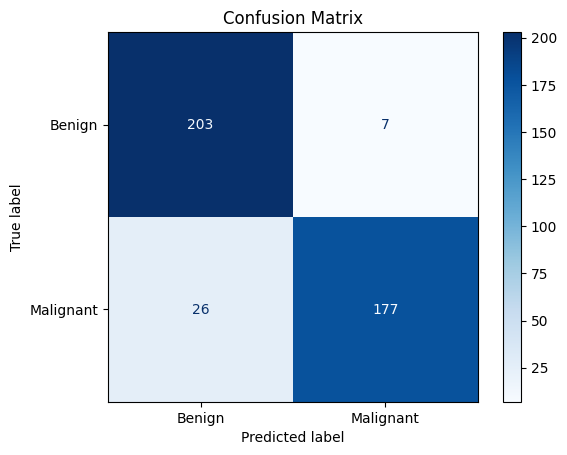

In [26]:
cm= confusion_matrix(y_true=y_test, y_pred=y_pred_2)
target_names = ["Benign", "Malignant"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

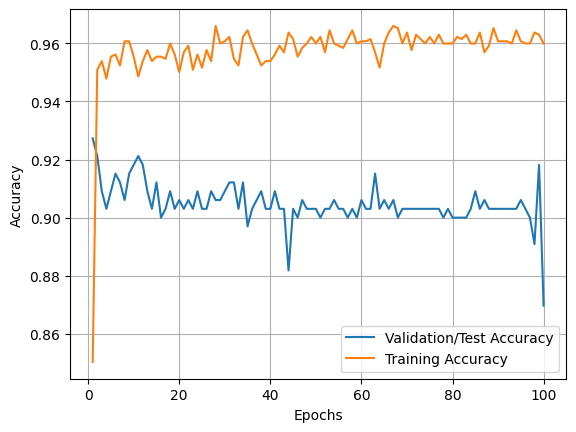

In [28]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

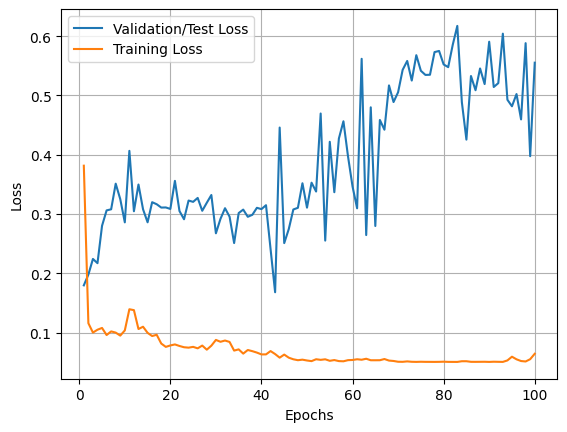

In [29]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


# Densenet121

In [13]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)

In [14]:
base_model.trainable=False

In [15]:

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121

# Load the pre-trained DenseNet121 model (without top layers)
# base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))



# We define the number of classes in the classification problem.
NUM_CLASSES = 2

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())
dummy_input = tf.zeros((1, 224, 224, 3))
_ = vgg_model(dummy_input)

intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])


# vgg_model.add(layers.Dropout(0.25))
# vgg_model.add(layers.Dense(256, activation='relu'))
# vgg_model.add(layers.Dense(128, activation='relu'))
# vgg_model.add(layers.Dense(64, activation='relu'))



vgg_model.add(layers.Dense(256, activation='relu'))
# vgg_model.add(layers.Dense(512, activation='relu'))

vgg_model.add(layers.Dense(32, activation='relu'))


vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False



vgg_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (1, 7, 7, 1024)        │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (1, 50176)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (1, 256)               │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (1, 32)                │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (1, 2)                 │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,891,106 (75.88 MB)

 Trainable params: 12,853,602 (49.03 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:


import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.densenet import DenseNet121

# Load the pre-trained DenseNet121 model (without top layers)
# base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(224, 224, 3))



# We define the number of classes in the classification problem.
NUM_CLASSES = 2

# First, a sequential model is created, which will be used to build the VGG model.
vgg_model = Sequential()

# Se agrega una capa al modelo. base_model el modelo anteriormente preentrenado.
vgg_model.add(base_model)

# A flattening layer (Flatten) is added. This layer converts the output from the
# previous layer (which is likely a three-dimensional tensor) into a one-dimensional vector.
vgg_model.add(layers.Flatten())
dummy_input = tf.zeros((1, 224, 224, 3))
_ = vgg_model(dummy_input)

intermediate_features = vgg_model.layers[-1].output
attention_weights = layers.Dense(1, activation='softmax')(intermediate_features)
attention_weights = layers.Reshape((1, 1, -1))(attention_weights)
attention_output = layers.Multiply()([intermediate_features, attention_weights])


# vgg_model.add(layers.Dropout(0.25))
# vgg_model.add(layers.Dense(256, activation='relu'))
# vgg_model.add(layers.Dense(128, activation='relu'))
# vgg_model.add(layers.Dense(64, activation='relu'))



vgg_model.add(layers.Dense(256, activation='relu'))
# vgg_model.add(layers.Dense(512, activation='relu'))

vgg_model.add(layers.Dense(32, activation='relu'))


vgg_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

# The first layer of the model (base_model) is frozen, so the weights of this layer
# will not be updated during training.
vgg_model.layers[0].trainable = False



vgg_model.summary()






# vgg_model.summary()

optimizer=keras.optimizers.Adam(learning_rate=0.0001)
losses=keras.losses.SparseCategoricalCrossentropy()
metrics=['accuracy']
vgg_model.compile(optimizer=optimizer,loss=losses,metrics=metrics)

epochs=20
batch_size=32
history= vgg_model.fit(X_train,y_train, epochs=100, batch_size=32, validation_data=(X_valid, y_valid))



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (1, 7, 7, 1024)        │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 22:45 33s/step - accuracy: 0.5938 - loss: 0.8895

I0000 00:00:1731045738.128678     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1731045738.200288     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step - accuracy: 0.7083 - loss: 0.9116

W0000 00:00:1731045756.776400     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1731045767.042158     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7105 - loss: 0.9030 - val_accuracy: 0.9030 - val_loss: 0.2347
Epoch 2/100
 1/42 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 0.0872

W0000 00:00:1731045781.353398     112 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9503 - loss: 0.1408 - val_accuracy: 0.9030 - val_loss: 0.2843
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9535 - loss: 0.1338 - val_accuracy: 0.9242 - val_loss: 0.2523
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9458 - loss: 0.1564 - val_accuracy: 0.9152 - val_loss: 0.1781
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9482 - loss: 0.1043 - val_accuracy: 0.9273 - val_loss: 0.1624
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9559 - loss: 0.0906 - val_accuracy: 0.9182 - val_loss: 0.1869
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.9591 - loss: 0.1013 - val_accuracy: 0.9212 - val_loss: 0.2820
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9591 - loss: 0.1288 - val_accuracy: 0.9273 - val_loss: 0.1966
Epoch 9/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.9494 - loss: 0.1139 - val_accuracy: 0.9333 - val_l

In [17]:

test_loss, test_accuracy = vgg_model.evaluate(X_test,y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)
y_pred = vgg_model.predict(X_test, verbose=1)
y_pred_2 = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_2))


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.9408 - loss: 0.1307


W0000 00:00:1731046201.382558     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Loss: 0.11375235766172409
Test Accuracy: 0.9491525292396545
 3/13 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step

W0000 00:00:1731046211.366769     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 831ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       210
           1       0.93      0.97      0.95       203

    accuracy                           0.95       413
   macro avg       0.95      0.95      0.95       413
weighted avg       0.95      0.95      0.95       413



W0000 00:00:1731046221.334019     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


<function matplotlib.pyplot.show(close=None, block=None)>

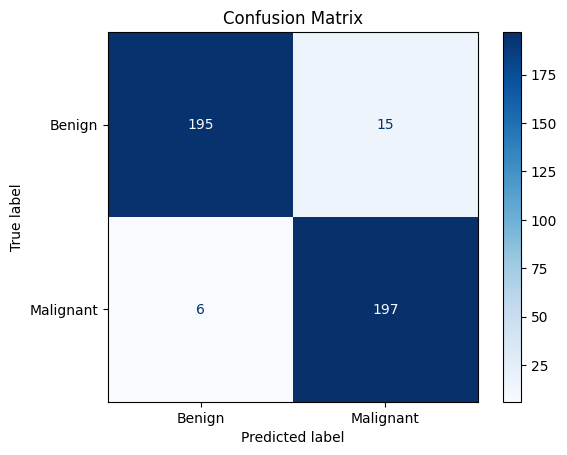

In [18]:
cm= confusion_matrix(y_true=y_test, y_pred=y_pred_2)
target_names = ["Benign", "Malignant"]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show


  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

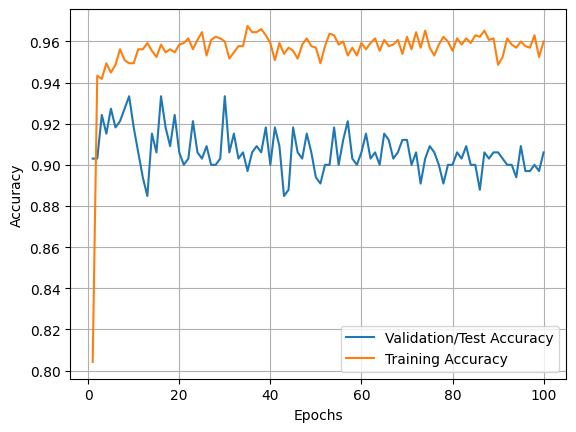

In [19]:
history_dict = history.history
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)
line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')
plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  animated: bool
  antialiased or aa: bool
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  color or c: color
  dash_capstyle: `.CapStyle` or {'butt', 'projecting', 'round'}
  dash_joinstyle: `.JoinStyle` or {'miter', 'round', 'bevel'}
  dashes: sequence of floats (on/off ink in points) or (None, None)
  data: (2, N) array or two 1D arrays
  drawstyle or ds: {'default', 'steps', 'steps-pre', 'steps-mid', 'steps-post'}, default: 'default'
  figure: `.Figure`
  fillstyle: {'full', 'left', 'right', 'bottom', 'top', 'none'}
  gapcolor: color or None
  gid: str
  in_layout: bool
  label: object
  linestyle or ls: {'-', '--', '-.', ':', '', (offset, on-off-seq), ...}
  linewidth or lw: float
  marker: marker style string, `~.path.Path` or `~.markers.MarkerStyle`

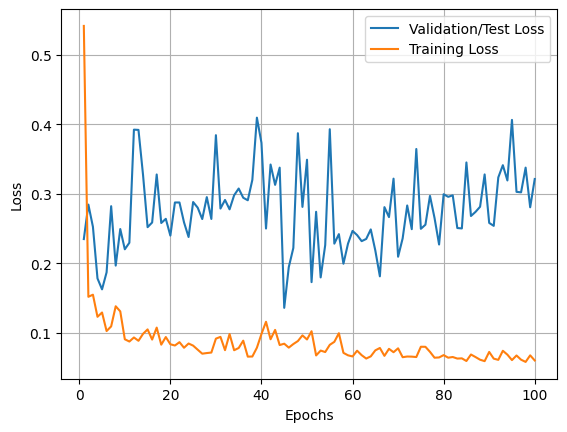

In [20]:
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')
plt.setp(line1)
plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()